# 01_SIFT — Autenticación de huellas con SIFT

### Este notebook asume que ya se ejecutó 00_preprocessing.ipynb, que generó:

###     user_database/ (subcarpetas userXX con imágenes  procesadas)
###     user_prueba/ (muestras para probar/verificar)

## 1) Imports y configuración

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Rutas 
USER_DB_DIR = '../user_database'
TEST_DIR = '../user_prueba' # imágenes nuevas para probar


# Parámetros SIFT y matching
RATIO_THRESHOLD = 0.75 
MATCH_THRESHOLD_AUTH = 100 


# Reproducibilidad (no afecta a SIFT en sí, pero mantiene orden estable de listados)
np.random.seed(42)

## 2) Utilidades SIFT: extracción y comparación

In [3]:
def extract_features(image_path):
    """Extrae descriptores SIFT de una imagen en escala de grises."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    sift = cv2.SIFT_create()
    _, descriptors = sift.detectAndCompute(image, None)
    return descriptors

def match_fingerprints(des1, des2, ratio_threshold=RATIO_THRESHOLD):
    """Compara dos conjuntos de descriptores SIFT y devuelve nº de good matches (ratio test)."""
    if des1 is None or des2 is None:
        return 0
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = bf.knnMatch(des1, des2, k=2)
    good_matches = [m for m, n in matches if m.distance < ratio_threshold * n.distance]
    return len(good_matches)

## 3) Evaluación tipo DET/EER

In [4]:
def evaluate_database(database_dir, test_dir, ratio_threshold=RATIO_THRESHOLD):
    """Devuelve true_labels y scores (máximo nº de matches SIFT con la BD por imagen de test)."""
    true_labels = []
    scores = []

    for test_image in os.listdir(test_dir):
        if not test_image.lower().endswith('.png'):
            continue
        test_path = os.path.join(test_dir, test_image)
        test_des = extract_features(test_path)

        max_matches = 0
        for user_folder in os.listdir(database_dir):
            user_path = os.path.join(database_dir, user_folder)
            if not os.path.isdir(user_path):
                continue
            for db_image in os.listdir(user_path):
                if not db_image.lower().endswith('.png'):
                    continue
                db_path = os.path.join(user_path, db_image)
                db_des = extract_features(db_path)
                matches = match_fingerprints(test_des, db_des, ratio_threshold)
                if matches > max_matches:
                    max_matches = matches

            # Etiquetas 
            true_labels.append(1 if ('s' in test_image or 'f' in test_image) else 0)
            scores.append(max_matches)

    return true_labels, scores

## 4) Visualización de coincidencias entre dos huellas

In [5]:
def visualize_matches(image1_path, image2_path, ratio_threshold=RATIO_THRESHOLD):
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = bf.knnMatch(des1, des2, k=2)
    good_matches = [m for m, n in matches if m.distance < ratio_threshold * n.distance]

    match_img = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(12, 8))
    plt.imshow(match_img, cmap='gray')
    plt.title(f"Coincidencias: {len(good_matches)}")
    plt.axis('off')
    plt.show()

## 5) Autenticación de una huella nueva

In [6]:
def authenticate_user(new_fingerprint_path, database_dir, match_threshold=MATCH_THRESHOLD_AUTH, ratio_threshold=RATIO_THRESHOLD):
    """Compara una huella con toda la BD y decide autenticación por umbral de good matches."""
    new_descriptors = extract_features(new_fingerprint_path)
    if new_descriptors is None:
        return None, None, "No se encontraron características en la huella nueva."

    max_matches = 0
    best_user = None
    best_match_path = None

    for user_dir in os.listdir(database_dir):
        user_path = os.path.join(database_dir, user_dir)
        if not os.path.isdir(user_path):
            continue
        for fingerprint_path in os.listdir(user_path):
            if not fingerprint_path.lower().endswith('.png'):
                continue
            full_path = os.path.join(user_path, fingerprint_path)
            db_descriptors = extract_features(full_path)
            if db_descriptors is None:
                continue
            match_count = match_fingerprints(new_descriptors, db_descriptors, ratio_threshold)
            # print(f"Comparando con {full_path}, Coincidencias: {match_count}") 
            if match_count > max_matches:
                max_matches = match_count
                best_user = user_dir
                best_match_path = full_path

    if max_matches >= match_threshold:
        return best_user, best_match_path, f"Huella autenticada como del usuario {best_user} con {max_matches} coincidencias."
    else:
        return best_user, best_match_path, f"Huella rechazada. Máximas coincidencias: {max_matches}"

## 6) Métricas DET y EER

In [7]:
def calculate_det(true_labels, scores):
    thresholds = sorted(set(scores))
    fpr_list, fnr_list = [], []

    for threshold in thresholds:
        tp = fp = tn = fn = 0
        for label, score in zip(true_labels, scores):
            if score >= threshold:
                if label == 1: tp += 1
                else: fp += 1
            else:
                if label == 1: fn += 1
                else: tn += 1
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        fpr_list.append(fpr)
        fnr_list.append(fnr)
    return fpr_list, fnr_list

def plot_det(fpr, fnr):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, fnr, linestyle='-', label="DET Curve")
    eer_index = np.nanargmin(np.abs(np.array(fpr) - np.array(fnr)))
    eer = (fpr[eer_index] + fnr[eer_index]) / 2
    eer_fpr, eer_fnr = fpr[eer_index], fnr[eer_index]
    plt.scatter(eer_fpr, eer_fnr, color='red', zorder=5, label=f"EER: {eer:.4f}")
    plt.annotate(f"EER = {eer:.4f}", xy=(eer_fpr, eer_fnr), xytext=(eer_fpr + 0.02, eer_fnr + 0.02),
    arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("False Negative Rate (FNR)")
    plt.title("DET Curve")
    plt.grid(True)
    plt.legend()
    plt.show()
    print(f"Equal Error Rate (EER): {eer:.4f}")

## 7) Ejecución: evaluación y ejemplo de autenticación

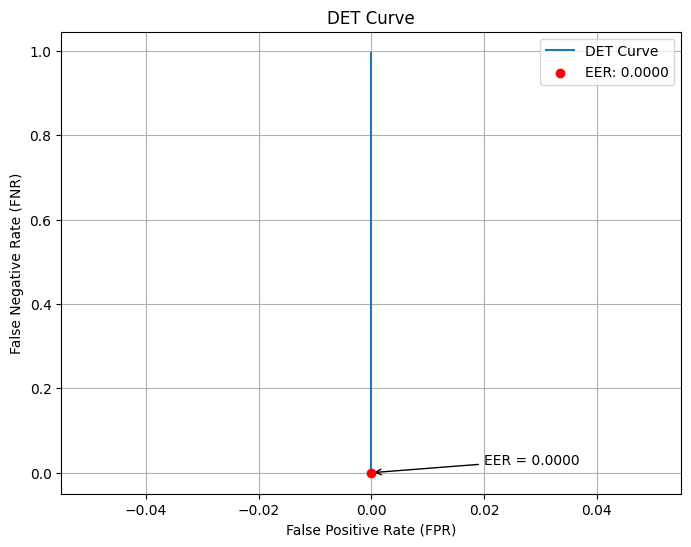

Equal Error Rate (EER): 0.0000
Huella autenticada como del usuario user11 con 3532 coincidencias.

Visualizando coincidencias con la huella de user11: ../user_database\user11\11f_01.png


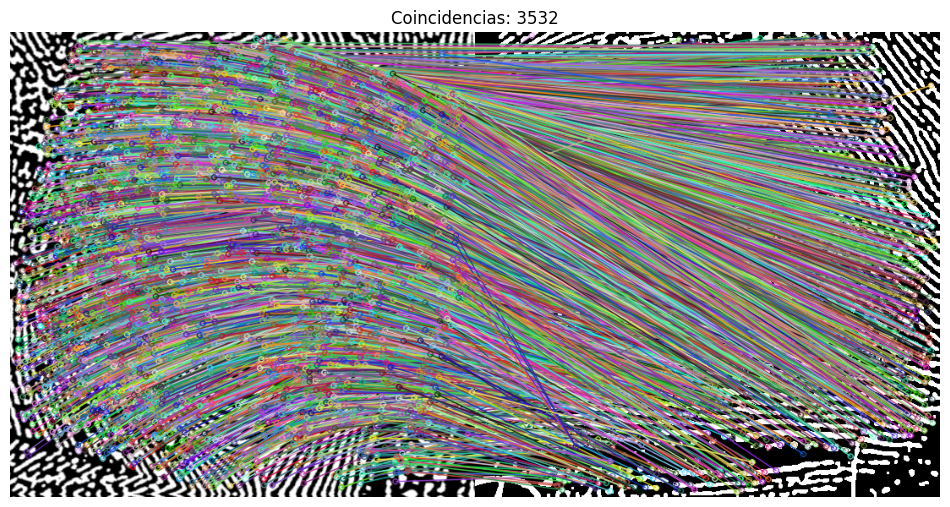

In [8]:
# 1) Evaluación (DET/EER)
true_labels, scores = evaluate_database(USER_DB_DIR, TEST_DIR, ratio_threshold=RATIO_THRESHOLD)
fpr, fnr = calculate_det(true_labels, scores)
plot_det(fpr, fnr)

# 2) Autenticar una huella concreta
example_fingerprint = None
for f in os.listdir(TEST_DIR):
    if f.lower().endswith('.png'):
        example_fingerprint = os.path.join(TEST_DIR, f)
        break

if example_fingerprint:
    best_user, best_match_path, result = authenticate_user(example_fingerprint, USER_DB_DIR,
                                                            match_threshold=MATCH_THRESHOLD_AUTH,
                                                            ratio_threshold=RATIO_THRESHOLD)
    print(result)
    if best_user and best_match_path:
        print(f"\nVisualizando coincidencias con la huella de {best_user}: {best_match_path}")
        visualize_matches(example_fingerprint, best_match_path, ratio_threshold=RATIO_THRESHOLD)
else:
    print('No se encontró una imagen de ejemplo en', TEST_DIR)